In [1]:
!pip install gym[classic_control]==0.26.2
!pip install stable-baselines3[extra]==2.0.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 7.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 48.0 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 7.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━

 --- Code to Clear Saved Data and Videos ---

"""
# Code to Clear Saved Data and Videos

Run this cell if you want to remove the directories and files created
by the previous training and demonstration steps.

This will delete:
- The log directory (./tmp/gym) containing monitor logs and saved models (best_model.zip and checkpoints).
- The video directories (untrained_agent_video, trained_agent_video_intermediate, trained_agent_video_best).

**Warning:** This action is irreversible!
"""


In [2]:
import os
import shutil

# Define the paths to be cleared (ensure these match the paths used in the main script)
log_dir = "./tmp/gym/"
video_folder_untrained = "untrained_agent_video"
video_folder_intermediate = "trained_agent_video_intermediate"
video_folder_best = "trained_agent_video_best"

# List of directories to remove
directories_to_clear = [
    log_dir,
    video_folder_untrained,
    video_folder_intermediate,
    video_folder_best
]

print("--- Clearing Directories and Files ---")

for directory in directories_to_clear:
    if os.path.exists(directory):
        print(f"Removing directory: {directory}")
        try:
            shutil.rmtree(directory)
            print(f"Successfully removed {directory}")
        except OSError as e:
            print(f"Error removing directory {directory}: {e}")
    else:
        print(f"Directory not found, skipping: {directory}")

print("--- Clearing Complete ---")

--- Clearing Directories and Files ---
Directory not found, skipping: ./tmp/gym/
Directory not found, skipping: untrained_agent_video
Directory not found, skipping: trained_agent_video_intermediate
Directory not found, skipping: trained_agent_video_best
--- Clearing Complete ---


In [3]:
# -*- coding: utf-8 -*-
"""
RL Demo: CartPole with Stable-Baselines3 in Colab

This script demonstrates basic Reinforcement Learning concepts
live environment.

It covers:
1. Setting up the environment (CartPole).
2. Showing an untrained agent's behavior.
3. Explaining the State, Action, and critically, the Reward function.
4. Training an agent using A2C from Stable-Baselines3.
5. Visualizing the training progress (reward curve).
6. Showing the trained agent's improved behavior.
"""

# --- Imports ---
import os
import base64
from typing import Callable
# Import time for optional frame delay (not strictly necessary for CartPole)
import time

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
# Import imageio for manual video saving
import imageio
import math

from stable_baselines3 import A2C
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback
from stable_baselines3.common.results_plotter import ts2xy, load_results


# Colab specific imports for video display
from IPython import display
from IPython.display import HTML

# --- Colab Setup ---
# This cell installs necessary libraries. Run this first.
# %pip install gymnasium stable-baselines3 stable-baselines3[extra] ipython

# Create necessary directories
log_dir = "./tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

# Helper function to display videos in Colab
def show_video(video_path, width=600):
    """Helper function to display video in Colab"""
    if not os.path.exists(video_path):
        print(f"Video file not found: {video_path}")
        return

    mp4 = open(video_path, 'rb').read()
    data_url = "data:video/mp4;base64," + base64.b64encode(mp4).decode()
    display.display(HTML(f'<video width="{width}" controls><source src="{data_url}" type="video/mp4"></video>'))

def find_videos(directory, prefix="rl-video-episode-"):
    """Find video files generated by RecordVideo in a directory."""
    # RecordVideo saves files like 'rl-video-episode-0.mp4', 'rl-video-episode-1.mp4', etc.
    # or uses the name_prefix if provided: 'your_prefix-episode-0.mp4'
    # Adjusting the prefix search slightly to be more general or specific
    video_files = sorted([f for f in os.listdir(directory) if f.endswith(".mp4") and prefix in f])
    # You might need to adjust the prefix check if RecordVideo naming changes,
    # but `prefix in f` is generally safer than `f.startswith(prefix)`
    return [os.path.join(directory, f) for f in video_files]

# --- Section 1: Introduction to the Environment (CartPole) ---

Welcome to this demonstration of Reinforcement Learning! We'll use a classic environment called **CartPole**.

Imagine a cart on a track, with a pole attached to a pivot on top. The goal is to keep the pole upright by moving the cart left or right.

- **State:** What information does our agent receive?
    - Position of the cart
    - Velocity of the cart
    - Angle of the pole
    - Angular velocity of the pole
    This is a continuous state space (floating-point numbers).

- **Action:** What can our agent do?
    - Push the cart to the left
    - Push the cart to the right
    This is a discrete action space (just two actions).

- **Episode:** A single attempt to balance the pole. It starts with the pole slightly off-center and ends when the pole falls too far, the cart goes off-screen, or a time limit (e.g., 500 steps) is reached.
"""


In [4]:
# Create the environment
# render_mode='rgb_array' is needed for recording video later
env = gym.make("CartPole-v1", render_mode="rgb_array")

print("--- Environment Details ---")
print(f"Observation Space (State): {env.observation_space}")
print(f"Action Space (Actions): {env.action_space}")
print("-------------------------")

# Reset the environment to get the initial state
obs, info = env.reset()
print(f"Initial State:\n {obs}")
env.close()

--- Environment Details ---
Observation Space (State): Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Action Space (Actions): Discrete(2)
-------------------------
Initial State:
 [ 0.02266574 -0.03529426  0.04644177  0.02874325]


# --- Section 2: Understanding the Reward Function ---


This is a crucial part of RL! The reward function defines the goal.

In CartPole:
- The agent receives a reward of **+1 for every single timestep** the pole remains upright.

Think about this:
- If the pole falls after 50 steps, the total reward for that episode is 50.
- If the pole stays upright for 100 steps, the total reward is 100.
- If the pole stays upright for the maximum allowed steps (e.g., 500), the total reward is 500.

What behavior does this reward function encourage?
-> Staying upright for as long as possible!
-> Maximizing the cumulative reward over an episode.
"""

# --- Section 3: Demonstrating an Untrained Agent (Random Actions) ---

Before training, let's see how the environment behaves with an agent that does nothing intelligent – it just takes random actions.

We expect it to fail quickly, as there's no strategy involved.
"""

In [5]:
# Create a new environment instance for demonstration
demo_env = gym.make("CartPole-v1", render_mode="rgb_array")

# --- Modification to show pole falling further ---
# Access the underlying environment object (unwrap it if wrappers are applied)
unwrapped_env = demo_env.unwrapped
# Change the angle threshold for termination
# Default is 12 degrees (0.2094 radians). Let's increase it to 20 degrees.
new_angle_threshold_degrees = 90
unwrapped_env.theta_threshold_radians = new_angle_threshold_degrees * math.pi / 180
unwrapped_env.x_threshold = 3.0
print(f"--- Temporarily increased pole angle threshold for demo to {new_angle_threshold_degrees} degrees ---")
# -------------------------------------------------


video_folder = "untrained_agent_video"
os.makedirs(video_folder, exist_ok=True)

# Record the first N episodes for demonstration
n_untrained_episodes = 3 # Record 3 episodes of the random agent
# The video_length=500 ensures we record up to the max steps per episode,
# but the episode will terminate earlier due to the modified angle threshold.
demo_env = gym.wrappers.RecordVideo(demo_env, video_folder, episode_trigger=lambda x: x < n_untrained_episodes, video_length=500) # Record first n episodes

print(f"--- Running Untrained Agent (Random Actions) for {n_untrained_episodes} episodes ---")

for episode in range(n_untrained_episodes):
    # Note: The RecordVideo wrapper automatically calls reset and handles the episode loop internally
    # when used with evaluate_policy or manual steps like below.
    # However, since we want to capture full episodes *ending* in failure visually,
    # we'll manually step through one episode per recorded video.
    # The episode_trigger and video_length handle starting/stopping recording.

    # Reset the environment (this is handled by the wrapper and the first step below,
    # but explicit reset is good practice if not using evaluate_policy)
    obs, info = demo_env.reset(seed=42 + episode) # Use different seed for each episode for variation

    total_reward = 0
    step_count = 0
    terminated = False
    truncated = False

    print(f"\n--- Episode {episode + 1} ---")

    # Run one episode until termination or truncation (with the MODIFIED threshold)
    while not (terminated or truncated):
        action = demo_env.action_space.sample() # Take a random action
        obs, reward, terminated, truncated, info = demo_env.step(action)
        total_reward += reward
        step_count += 1

    print(f"Episode finished after {step_count} steps.")
    print(f"Total reward: {total_reward}")
    print(f"Termination status: Terminated={terminated}, Truncated={truncated}")
    print("--------------------------")

demo_env.close() # Close the wrapped environment

# Display the recorded videos
print(f"\n--- Untrained Agent Videos ({n_untrained_episodes} episodes) ---")
video_files = sorted([f for f in os.listdir(video_folder) if f.endswith(".mp4")])
if video_files:
    for i, video_file in enumerate(video_files):
        # Check if the video file is reasonably sized before trying to display
        # Sometimes RecordVideo can produce tiny files if it errors or stops immediately
        if os.path.getsize(os.path.join(video_folder, video_file)) > 1000: # Simple check
             print(f"Video {i+1}/{len(video_files)}:")
             show_video(os.path.join(video_folder, video_file))
        else:
             print(f"Skipping display for potentially empty or very small video: {video_file}")
else:
    print("No videos were successfully recorded for the untrained agent.")

--- Temporarily increased pole angle threshold for demo to 90 degrees ---
--- Running Untrained Agent (Random Actions) for 3 episodes ---


/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/record_video.py:87: UserWarning: WARN: Overwriting existing videos at /content/untrained_agent_video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(



--- Episode 1 ---
Episode finished after 50 steps.
Total reward: 50.0
Termination status: Terminated=True, Truncated=False
--------------------------

--- Episode 2 ---
Episode finished after 47 steps.
Total reward: 47.0
Termination status: Terminated=True, Truncated=False
--------------------------

--- Episode 3 ---
Episode finished after 42 steps.
Total reward: 42.0
Termination status: Terminated=True, Truncated=False
--------------------------


/usr/local/lib/python3.11/dist-packages/moviepy/config_defaults.py:1: DeprecationWarning: invalid escape sequence '\P'
  """


Moviepy - Building video /content/untrained_agent_video/rl-video-episode-0.mp4.
Moviepy - Writing video /content/untrained_agent_video/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/untrained_agent_video/rl-video-episode-0.mp4

--- Untrained Agent Videos (3 episodes) ---
Video 1/1:


# --- Section 4: Choosing an Algorithm and Training Setup ---

To train an agent, we need an algorithm. There are many!

We'll use **A2C (Advantage Actor-Critic)** from the Stable-Baselines3 library.
- A2C is an Actor-Critic algorithm.
    - **Actor:** Learns a *policy* (a strategy) - mapping states to actions.
    - **Critic:** Learns a *value function* - estimating how good a state is (expected future reward).
- They learn together, using the critic's estimate to improve the actor's policy.

Stable-Baselines3 provides robust implementations. We'll use the `A2C` class with a simple `MlpPolicy` (Multi-Layer Perceptron neural network) as the function approximator for both actor and critic.

To monitor training, we'll use an `EvalCallback`. This callback periodically evaluates the agent on a separate environment and logs the performance (like average reward). This is essential for seeing if the agent is actually learning.
"""

In [6]:
# Define evaluation parameters
eval_freq = 1000  # Evaluate every 1000 timesteps
n_eval_episodes = 10 # Evaluate over 10 episodes
eval_env_id = 'CartPole-v1'

# Create a separate evaluation environment (uses DEFAULT CartPole-v1)
# Wrap the eval env with Monitor to record episode stats for the EvalCallback
eval_env = make_vec_env(eval_env_id, n_envs=1, seed=42)
unwrapped_env = demo_env.unwrapped
# Change the angle threshold for termination
# Default is 12 degrees (0.2094 radians). Let's increase it to 20 degrees.
new_angle_threshold_degrees = 90
unwrapped_env.theta_threshold_radians = new_angle_threshold_degrees * math.pi / 180
unwrapped_env.x_threshold = 3.0
eval_env = Monitor(eval_env.envs[0], log_dir) # Monitor needs a single env

# Create the EvalCallback
eval_callback = EvalCallback(eval_env,
                             best_model_save_path=log_dir,
                             log_path=log_dir,
                             eval_freq=eval_freq,
                             n_eval_episodes=n_eval_episodes,
                             deterministic=True, # Use deterministic actions during eval
                             render=False) # No rendering during evaluation training

# Create the CheckpointCallback
# Save model every 'save_freq' timesteps
save_freq = 1000 # Save a checkpoint every 5000 steps
# Ensure the save directory exists
os.makedirs(log_dir + "/checkpoints", exist_ok=True)
checkpoint_callback = CheckpointCallback(save_freq=save_freq, save_path=log_dir + "/checkpoints/",
                                         name_prefix="rl_model")

# --- Section 5: Training the Agent ---

Now, let's train the A2C agent.

We'll train for a set number of timesteps. Watch the output (if verbose > 0) or simply wait for it to complete. The `EvalCallback` will print messages periodically showing the evaluation results.

The `learn()` method is where the magic happens - the agent interacts with the environment, collects data, and updates its policy and value function using the A2C algorithm.
"""

In [7]:
# Create the A2C model (uses DEFAULT CartPole-v1 parameters)
# Policy: MlpPolicy
# Environment: CartPole-v1
# verbose=0 to keep output clean during lecture, set to 1 or 2 for more details
# seed for reproducibility
model = A2C("MlpPolicy", "CartPole-v1", verbose=0, seed=0)

print("\n--- Training the Agent ---")
# Train the model
# Pass both callbacks
total_timesteps = 8000 # Number of steps to train for. 10k-20k is usually enough for CartPole to solve.
print(f"Training for {total_timesteps} timesteps...")
model.learn(total_timesteps=total_timesteps, callback=[eval_callback, checkpoint_callback]) # Use a list for multiple callbacks
print("Training finished.")
print("--------------------------")


--- Training the Agent ---
Training for 8000 timesteps...
Eval num_timesteps=1000, episode_reward=107.50 +/- 41.70
Episode length: 107.50 +/- 41.70
New best mean reward!
Eval num_timesteps=2000, episode_reward=63.90 +/- 17.06
Episode length: 63.90 +/- 17.06
Eval num_timesteps=3000, episode_reward=96.40 +/- 27.36
Episode length: 96.40 +/- 27.36
Eval num_timesteps=4000, episode_reward=194.80 +/- 130.40
Episode length: 194.80 +/- 130.40
New best mean reward!
Eval num_timesteps=5000, episode_reward=463.70 +/- 72.60
Episode length: 463.70 +/- 72.60
New best mean reward!
Eval num_timesteps=6000, episode_reward=493.70 +/- 18.90
Episode length: 493.70 +/- 18.90
New best mean reward!
Eval num_timesteps=7000, episode_reward=500.00 +/- 0.00
Episode length: 500.00 +/- 0.00
New best mean reward!
Eval num_timesteps=8000, episode_reward=500.00 +/- 0.00
Episode length: 500.00 +/- 0.00
Training finished.
--------------------------


# --- Section 6: Visualizing Training Progress ---

Did the agent actually learn? We can see this by plotting the evaluation results collected by the `EvalCallback`.

We'll plot the average reward obtained during evaluation episodes against the number of training timesteps. A successful learning process will show the average reward increasing over time.
"""


--- Plotting Training Progress ---


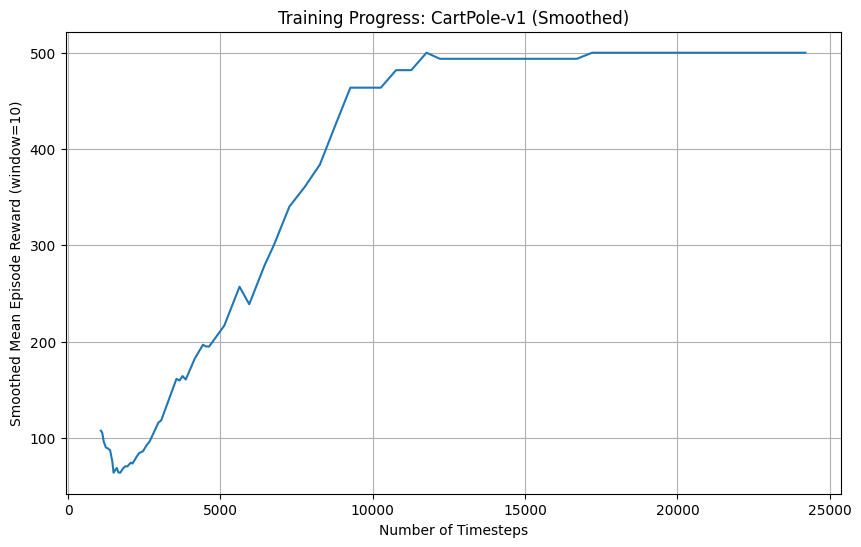

Smoothed plot displayed above.
Smoothing window size: 10


In [8]:
print("\n--- Plotting Training Progress ---")

# Load the results from the log directory
# 'monitor.csv' is the file where Monitor/EvalCallback logs results
# Check if monitor.csv exists first
monitor_file_path = os.path.join(log_dir, 'monitor.csv')
if os.path.exists(monitor_file_path):
    # ts2xy extracts the timesteps (x) and mean rewards (y)
    x, y = ts2xy(load_results(log_dir), 'timesteps')

    if len(x) > 0:
        # --- Smoothing the data ---
        smoothing_window = 10 # Define the window size for smoothing. Adjust as needed.
        # Use convolution to compute the moving average
        # Create a window (a list of 1/window_size)
        window = np.ones(smoothing_window) / smoothing_window
        # Convolve the data with the window
        y_smoothed = np.convolve(y, window, mode='valid') # 'valid' mode returns convolution where window fully overlaps
        # The corresponding x values are shifted because of 'valid' mode.
        # A simple approach is to align the smoothed points with the end of the window,
        # but for visualization, aligning with the start or center or just taking
        # the corresponding range of x values is common. Let's align with the end of the window.
        x_smoothed = x[smoothing_window - 1:]
        # --------------------------


        plt.figure(figsize=(10, 6))
        # Plot the smoothed data
        plt.plot(x_smoothed, y_smoothed)
        # Optional: Plot raw data underneath with transparency for context
        # plt.plot(x, y, alpha=0.3, label='Raw')
        plt.xlabel("Number of Timesteps")
        plt.ylabel(f"Smoothed Mean Episode Reward (window={smoothing_window})")
        plt.title("Training Progress: CartPole-v1 (Smoothed)")
        plt.grid(True)
        # plt.legend() # Uncomment if plotting raw data
        plt.show()
        print("Smoothed plot displayed above.")
        print(f"Smoothing window size: {smoothing_window}")
    else:
        print("No data logged in monitor.csv to plot.")
        print(f"Check if the eval_callback saved results to: {monitor_file_path}")
else:
    print(f"Monitor file not found at: {monitor_file_path}")
    print("Training evaluation data was not logged.")



# --- Section 7: Demonstrating the Trained Agent ---


Now for the moment of truth! Let's load the *best* model saved during training (based on evaluation performance) and see how it performs.

We expect it to balance the pole for much longer than the random agent, ideally reaching the maximum number of steps per episode.
"""

In [9]:
print("\n--- Demonstrating Trained Agents ---")

n_trained_demo_episodes = 3 # Number of episodes to demonstrate for each trained agent
max_episode_steps = 500 # Max steps for CartPole-v1

# --- Demonstration of Intermediate Agent ---
intermediate_steps = 3000 # The timestep we want to load
intermediate_model_path = os.path.join(log_dir, "checkpoints", f"rl_model_{intermediate_steps}_steps.zip")

if os.path.exists(intermediate_model_path):
    print(f"\n--- Intermediate Agent (at {intermediate_steps} steps) ---")
    loaded_intermediate_model = A2C.load(intermediate_model_path)
    print(f"Loaded intermediate model from: {intermediate_model_path}")

    # Create a new environment for the intermediate demo (uses DEFAULT CartPole-v1)
    demo_env_intermediate = gym.make("CartPole-v1", render_mode="rgb_array")
    unwrapped_env = demo_env_intermediate.unwrapped
    # Change the angle threshold for termination
    # Default is 12 degrees (0.2094 radians). Let's increase it to 20 degrees.
    new_angle_threshold_degrees = 90
    unwrapped_env.theta_threshold_radians = new_angle_threshold_degrees * math.pi / 180
    unwrapped_env.x_threshold = 3.0
    video_folder_intermediate = "trained_agent_video_intermediate"
    os.makedirs(video_folder_intermediate, exist_ok=True)
    # Record N episodes into potentially one video file (if wrapper supports, often separate files)
    # video_length ensures we record the full 500 steps if successful
    demo_env_intermediate = gym.wrappers.RecordVideo(
        demo_env_intermediate,
        video_folder_intermediate,
        episode_trigger=lambda x: x < n_trained_demo_episodes,
        video_length=max_episode_steps,
        name_prefix="intermediate_agent_episode" # Custom prefix for clarity
    )

    print(f"Running intermediate agent for {n_trained_demo_episodes} episodes on standard CartPole-v1...")
    # evaluate_policy handles running multiple episodes and interacting with the wrapper
    mean_reward_intermediate, std_reward_intermediate = evaluate_policy(
        loaded_intermediate_model,
        demo_env_intermediate,
        n_eval_episodes=n_trained_demo_episodes,
        deterministic=True # Use deterministic for consistent demo
    )

    print(f"\nEvaluation results for intermediate agent over {n_trained_demo_episodes} episodes:")
    print(f"Mean reward: {mean_reward_intermediate:.2f} +/- {std_reward_intermediate:.2f}")
    print("----------------------------------------------")

    demo_env_intermediate.close()

    # Display the recorded videos for the intermediate agent
    print(f"\n--- Intermediate Agent Videos ({n_trained_demo_episodes} episodes) ---")
    video_files_intermediate = find_videos(video_folder_intermediate, prefix="intermediate_agent_episode")
    if video_files_intermediate:
        for i, video_file in enumerate(video_files_intermediate):
            if os.path.getsize(video_file) > 1000: # Simple check
                 print(f"Video {i+1}/{len(video_files_intermediate)}:")
                 show_video(video_file)
            else:
                 print(f"Skipping display for potentially empty or very small video: {video_file}")
    else:
         print("No videos recorded for the intermediate agent.")

else:
    print(f"\nIntermediate model not found at: {intermediate_model_path}")
    print(f"Unable to demonstrate the intermediate agent. Check if checkpoint at {intermediate_steps} steps was saved.")
    print("----------------------------------------------")


# --- Demonstration of Best Agent ---
best_model_path = os.path.join(log_dir, "best_model.zip")
if os.path.exists(best_model_path):
    print(f"\n--- Best Trained Agent ---")
    loaded_best_model = A2C.load(best_model_path)
    print(f"Loaded best model from: {best_model_path}")

    # Create a new environment for the best agent demo (uses DEFAULT CartPole-v1)
    demo_env_best = gym.make("CartPole-v1", render_mode="rgb_array")
    unwrapped_env = demo_env_best.unwrapped
    # Change the angle threshold for termination
    # Default is 12 degrees (0.2094 radians). Let's increase it to 20 degrees.
    new_angle_threshold_degrees = 90
    unwrapped_env.theta_threshold_radians = new_angle_threshold_degrees * math.pi / 180
    unwrapped_env.x_threshold = 3.0
    video_folder_best = "trained_agent_video_best"
    os.makedirs(video_folder_best, exist_ok=True)
    # Record N episodes
    demo_env_best = gym.wrappers.RecordVideo(
        demo_env_best,
        video_folder_best,
        episode_trigger=lambda x: x < n_trained_demo_episodes,
        video_length=max_episode_steps,
        name_prefix="best_agent_episode" # Custom prefix
    )

    print(f"Running best agent for {n_trained_demo_episodes} episodes on standard CartPole-v1...")
    # evaluate_policy handles running multiple episodes and interacting with the wrapper
    mean_reward_best, std_reward_best = evaluate_policy(
        loaded_best_model,
        demo_env_best,
        n_eval_episodes=n_trained_demo_episodes,
        deterministic=True # Use deterministic for consistent demo
    )

    print(f"\nEvaluation results for best agent over {n_trained_demo_episodes} episodes:")
    print(f"Mean reward: {mean_reward_best:.2f} +/- {std_reward_best:.2f}")
    print("----------------------------------------------")

    demo_env_best.close()

    # Display the recorded videos for the best agent
    print(f"\n--- Best Agent Videos ({n_trained_demo_episodes} episodes) ---")
    video_files_best = find_videos(video_folder_best, prefix="best_agent_episode")
    if video_files_best:
        for i, video_file in enumerate(video_files_best):
            if os.path.getsize(video_file) > 1000: # Simple check
                 print(f"Video {i+1}/{len(video_files_best)}:")
                 show_video(video_file)
            else:
                 print(f"Skipping display for potentially empty or very small video: {video_file}")
    else:
         print("No videos recorded for the best agent.")

else:
    print(f"\nBest model not found at: {best_model_path}")
    print("Unable to demonstrate the best agent.")
    print("Please ensure training completed successfully and saved the best model.")
    print("----------------------------------------------")



--- Demonstrating Trained Agents ---

--- Intermediate Agent (at 3000 steps) ---
Loaded intermediate model from: ./tmp/gym/checkpoints/rl_model_3000_steps.zip
Running intermediate agent for 3 episodes on standard CartPole-v1...


/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/record_video.py:87: UserWarning: WARN: Overwriting existing videos at /content/trained_agent_video_intermediate folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(



Evaluation results for intermediate agent over 3 episodes:
Mean reward: 164.33 +/- 36.08
----------------------------------------------
Moviepy - Building video /content/trained_agent_video_intermediate/intermediate_agent_episode-episode-0.mp4.
Moviepy - Writing video /content/trained_agent_video_intermediate/intermediate_agent_episode-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/trained_agent_video_intermediate/intermediate_agent_episode-episode-0.mp4

--- Intermediate Agent Videos (3 episodes) ---
Video 1/1:



--- Best Trained Agent ---
Loaded best model from: ./tmp/gym/best_model.zip
Running best agent for 3 episodes on standard CartPole-v1...


/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/record_video.py:87: UserWarning: WARN: Overwriting existing videos at /content/trained_agent_video_best folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video /content/trained_agent_video_best/best_agent_episode-episode-0.mp4.
Moviepy - Writing video /content/trained_agent_video_best/best_agent_episode-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/trained_agent_video_best/best_agent_episode-episode-0.mp4
Moviepy - Building video /content/trained_agent_video_best/best_agent_episode-episode-1.mp4.
Moviepy - Writing video /content/trained_agent_video_best/best_agent_episode-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /content/trained_agent_video_best/best_agent_episode-episode-1.mp4
Moviepy - Building video /content/trained_agent_video_best/best_agent_episode-episode-2.mp4.
Moviepy - Writing video /content/trained_agent_video_best/best_agent_episode-episode-2.mp4



Moviepy - Done !
Moviepy - video ready /content/trained_agent_video_best/best_agent_episode-episode-2.mp4

Evaluation results for best agent over 3 episodes:
Mean reward: 500.00 +/- 0.00
----------------------------------------------

--- Best Agent Videos (3 episodes) ---
Video 1/3:


Video 2/3:


Video 3/3:


# --- Conclusion ---


We've seen:
1. The CartPole environment: its state and action spaces.
2. The crucial role of the **Reward Function** (+1 per step upright).
3. How a random agent performs (poorly).
4. How an RL algorithm (A2C) learns by maximizing cumulative reward.
5. Visual evidence of learning through the reward curve.
6. The improved performance of the trained agent.

This is a simple example, but the core concepts (State, Action, Reward, Policy, Value, Training to maximize cumulative reward) apply to much more complex problems like robotics, game playing, and more!
